# AutoML Basics, InnerWorkings and Interpretations

Authored by Midhun Mohan for AI SkunkWorks

### What is AutoML?
Automactic Machine Learning or AutoML refers to the automation of various tasks in the machine learning pipeline, including data preprocessing, hyperparameter tuning, model selection, and evaluation. 

This notebook explores the use of an open-source [automated machine learning package from H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html) to speed up the development of models.

In [18]:
#Installing required packages
%%ignore

!pip3 install h2o


UsageError: Line magic function `%%ignore` not found.


In [19]:
#Importing required packages
import h2o
from h2o.automl import H2OAutoML


### Initialize the H2O Cluster

In [20]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,33 mins 51 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_mohan_nf617i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.343 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Data Preperation

We will employ a dataset sourced from Kaggle, the [Amazon Business Research Analyst Dataset](https://www.kaggle.com/datasets/vikramxd/amazon-business-research-analyst-dataset?select=cleaned_test.csv), to explore the logistical aspects involved in delivering packages from their source to their final destination. The dataset provides information on variables such as driver age,driver ratings, type of vehicle used, traffic conditions, weather, and day of the year etc. The target variable of interest is the time taken to deliver a package.

We will be utilizing H2O's AutoML to train and tune various models to identify the best performing model for our Amazon Business Research Analyst Dataset.

#### Load the dataset as a H2OFrame

In [21]:
df = h2o.import_file('../../CSV/Amazon_Delivery_Times.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### Describe the dataset. H2O provides 10 rows of sample data along with basic summary statistics for numerical columns.

In [22]:
df.describe(chunk_summary=True)

Rows:2442
Cols:20

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size     size_percentage
------------  -------------------------  -------  ------------------  -------  -----------------
C0L           Constant long              4        0.625               320  B   0.211423
C1            1-Byte Integers            56       8.75                7.9 KB   5.34175
C1N           1-Byte Integers (w/o NAs)  327      51.0938             46.1 KB  31.1764
C1S           1-Byte Fractions           61       9.53125             9.5 KB   6.46097
C2            2-Byte Integers            32       5                   6.9 KB   4.66453
C4S           4-Byte Fractions           128      20                  48.7 KB  32.9186
CStr          Strings                    32       5                   28.4 KB  19.2263

Frame distribution summary: 
                 size      number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  --------  ----------------  -----------------------------  ------------------
127.0.0.1:54321  147.8 KB  2442              32                             640
mean             147.8 KB  2442              32                             640
min              147.8 KB  2442              32                             640
max              147.8 KB  2442              32                             640
stddev           0  B      0                 0                              0
total            147.8 KB  2442              32                             640

,C1,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
type,int,string,enum,int,real,real,real,real,real,enum,enum,int,int,int,int,int,int,int,int,int
mins,1.0,NaN,,0.0,2.5,-30.902872,-85.335486,0.01,0.01,,,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,10.0
mean,1221.5,NaN,,28.404995904995904,4.630110732538331,17.153255966420964,71.03089396560198,17.57936625962326,71.47972809991812,,,2.694922194922195,1.7424242424242424,0.9938574938574939,1.4979524979524979,3.2534807534807535,0.7625628140703518,1.0278460278460277,1.5401310401310404,26.487714987714988
maxs,2442.0,NaN,,50.0,6.0,30.914057,88.433452,31.035562,88.50331,,,7.0,5.0,3.0,3.0,4.0,3.0,3.0,4.0,54.0
sigma,705.089001474282,NaN,,8.026136612757885,0.3153380391156618,8.00777283804197,21.512858776292536,7.183449281426879,20.19997041370754,,,2.011205503398818,1.0044931521019773,0.8352407710350878,1.127745820655363,0.5929033451828123,0.5576797928867177,0.18998530539617242,0.9254397978063458,9.339518207491592
zeros,0,0,,93,0,176,176,0,0,,,408,250,837,622,0,706,0,0,0
missing,0,0,0,0,94,0,0,0,0,89,0,0,0,0,0,0,54,0,0,0
0,1.0,0x4607_x,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,11:30,11:45,4.0,0.0,2.0,3.0,3.0,0.0,1.0,3.0,24.0
1,2.0,0xb379_x,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,19:45,19:50,3.0,1.0,2.0,3.0,4.0,1.0,1.0,1.0,33.0
2,3.0,0x20f7_x,BANGRES18DEL01,37.0,4.4,12.913041,77.683237,12.953041,77.723237,13:50,13:55,6.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,42.0


#### Split the dataset into train and test set

In [23]:
train, test = df.split_frame(ratios=[0.8], seed = 1)

### Train AutoML Models

Let's configure the AutoML training parameters.
```
max_models: Maximum number of models to train
balance_classes: set to True to balance the class labels for tasks with imbalance data
seed : Set for reproducibility
```

In [24]:
aml = H2OAutoML(max_models =25,
                balance_classes=True,
		seed =1)

We can limit the amount of time spent on searching for the best model by limiting: <br>
```
1. maximum number of models using max_models
2. total time spent using max_runtime_secs
3. time spend training any single model using max_runtime_secs_per_model
```
Start the training by specifying: </br>
```
1. training_frame: the dataframe that contains training data -- train in our case
2. y: the column in the training_frame which contains the target variable -- Time_taken(min) in our case
```

In [25]:
aml.train(training_frame = train, y = 'Time_taken(min)')

AutoML progress: |
18:41:17.350: _train param, Dropping bad and constant columns: [ID]


18:41:18.577: _train param, Dropping bad and constant columns: [ID]

█
18:41:19.809: _train param, Dropping bad and constant columns: [ID]

█
18:41:20.679: _train param, Dropping bad and constant columns: [ID]


18:41:21.326: _train param, Dropping bad and constant columns: [ID]

████
18:41:24.845: _train param, Dropping bad and constant columns: [ID]

█
18:41:26.49: _train param, Dropping bad and constant columns: [ID]

███
18:41:27.709: _train param, Dropping bad and constant columns: [ID]
18:41:29.275: _train param, Dropping bad and constant columns: [ID]
18:41:29.705: _train param, Dropping bad and constant columns: [ID]

██████
18:41:40.617: _train param, Dropping bad and constant columns: [ID]

█
18:41:41.911: _train param, Dropping bad and constant columns: [ID]
18:41:41.969: DeepLearning_1_AutoML_2_20230214_184117 [DeepLearning def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentE

key,value
Stacking strategy,cross_validation
Number of base models (used / total),15/40
# GBM base models (used / total),2/9
# XGBoost base models (used / total),13/28
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In addition we can also specify <mark>validation_frame</mark> which is a H2OFrame that the model is evaluated on during training. If this parameter is not set, the model will be evaluated using k-fold cross validation. Refer to the [documentation](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#optional-data-parameters) for other optional parameters.

#### What's happening under the hood?

H2O AutoML trains the following models in a sequential order:
```
Three pre-specified XGBoost GBM (Gradient Boosting Machine) models
A fixed grid of GLMs
A default Random Forest (DRF)
Five pre-specified H2O GBMs
A near-default Deep Neural Net
An Extremely Randomized Forest (XRT)
A random grid of XGBoost GBMs
A random grid of H2O GBMs
A random grid of Deep Neural Nets
```
In addition to these models, H2O AutoML also trains:
```
A stacked ensemble of all the models trained above
A "Best of Family" Stacked Ensemble that contains the best performing model for each algorithm class.
```

### Interpretting the above training output:

The reported metrics are for the stacked ensemble model in H2O AutoML. The metrics are reported separately for the training data and the cross-validation data.

For the training data:
```
Mean Squared Error (MSE) is 8.9786, which measures the average squared difference between the predicted and actual values.
Root Mean Squared Error (RMSE) is 2.9964, which is the square root of MSE and provides a measure of how well the model fits the data.
Mean Absolute Error (MAE) is 2.3433, which measures the average absolute difference between the predicted and actual values.
Root Mean Squared Log Error (RMSLE) is 0.1225, which is the RMS of the logarithmic differences between the predicted and actual values.
R-squared (R^2) is 0.8977, which is a measure of how well the model fits the data.
The Null deviance, residual deviance, and AIC are also reported.
```
For the cross-validation data:
```
The metrics are generally worse than for the training data, which is expected since the model was not trained on this data.
The R^2 is 0.6821, which is still a reasonable fit but lower than for the training data.
The other metrics are also worse, indicating that the model may be overfitting on the training data.
```


### Evaluation:
After the models are trained, we can compare the model performance using the leaderboard. H2O AutoML produces a leaderboard which ranks the trained model based on a predefined metric. By default it ranks models by ascending order of logloss and rmse for classification and regression task respectively.

In [26]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20230214_184117,5.28344,27.9147,4.12673,0.20837,27.9147
XGBoost_grid_1_AutoML_2_20230214_184117_model_29,5.46001,29.8117,4.28308,0.214441,29.8117
StackedEnsemble_BestOfFamily_1_AutoML_2_20230214_184117,5.46615,29.8788,4.29547,0.214735,29.8788
XGBoost_grid_1_AutoML_2_20230214_184117_model_22,5.48132,30.0449,4.32262,0.215469,30.0449
XGBoost_grid_1_AutoML_2_20230214_184117_model_3,5.50117,30.2629,4.29018,0.21723,30.2629
XGBoost_grid_1_AutoML_2_20230214_184117_model_21,5.51285,30.3915,4.31581,0.218527,30.3915
XGBoost_grid_1_AutoML_2_20230214_184117_model_25,5.53848,30.6748,4.32828,0.220916,30.6748
XGBoost_grid_1_AutoML_2_20230214_184117_model_26,5.558,30.8913,4.35825,0.22147,30.8913
XGBoost_grid_1_AutoML_2_20230214_184117_model_27,5.57446,31.0747,4.36586,0.220346,31.0747
XGBoost_grid_1_AutoML_2_20230214_184117_model_24,5.59897,31.3484,4.37476,0.220763,31.3484


### Best Performing Model 

In [27]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20230214_184117


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  15/40
# GBM base models (used / total)      2/9
# XGBoost base models (used / total)  13/28
# DRF base models (used / total)      0/2
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 8.978551763125914
RMSE: 2.9964231615587797
MAE: 2.343328881198961
RMSLE: 0.12253867794462038
Mean Residual Deviance: 8.978551763125914
R^2: 0.8977404891718397
Null degrees of freedom: 1954
Resid

### How did AutoML pick this model?
The difference between the first 3 models in the leaderboard is that the first two are ensemble models that combine multiple models to make predictions, while the third is a single XGBoost model. The Stacked Ensemble models use a combination of models to make predictions and generally result in better performance compared to a single model.

The model that was probably chosen as the best model is the "StackedEnsemble_AllModels_1_AutoML_1_20230214_162143" model because it has the lowest RMSE, which is a commonly used measure of the prediction error in regression problems. However, it is important to evaluate the model based on other metrics and use cross-validation to get a more accurate estimate of the model's performance on unseen data.

### Evaluating the best model on a holdout test set using the same evaluation metrics shown above.

In [28]:
best_model.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 24.963128453159886
RMSE: 4.996311484801551
MAE: 3.984201482600476
RMSLE: 0.20364503036825107
Mean Residual Deviance: 24.963128453159886
R^2: 0.7045669736205955
Null degrees of freedom: 486
Residual degrees of freedom: 471
Null deviance: 41297.346203386944
Residual deviance: 12157.043556688865
AIC: 2982.9198701328814

### Let's examine its results.

```
MSE (Mean Squared Error): In this case, the MSE is 24.96, which means that the average squared difference between the predicted and actual delivery times is about 24.96.

RMSE (Root Mean Squared Error):is the square root of MSE and is used to provide a more interpretable measure of error in the same units as the target variable. The RMSE in this case is 4.996, which means that on average the predictions are off by about 5 minutes.

MAE (Mean Absolute Error): In this case, the MAE is 3.984, which means that on average the predictions are off by about minutes.

RMSLE (Root Mean Squared Log Error): measures the ratio between the predicted and actual values, where the values are first log-transformed. In this case, the RMSLE is 0.203, which means that the predicted values are off by about 20% on average.

Mean Residual Deviance: measures the variance of the residuals, which is the difference between the predicted and actual values. A lower value indicates a better fit. In this case, the mean residual deviance is 24.96 minutes.

R^2 (Coefficient of Determination): A value of 1 indicates a perfect fit, while a value of 0 indicates that the model does not explain any of the variance. In this case, the R^2 is 0.705, which means that the model explains about 70% of the variance in the delivery times.

Null degrees of freedom and residual degrees of freedom: are the degrees of freedom for the null model (a model with no predictors) and the residual model, respectively. In this case, there are 486 null degrees of freedom and 471 residual degrees of freedom.

Null deviance and residual deviance: measure the deviance of the null model and residual model, respectively. A lower value indicates a better fit. In this case, the null deviance is 41297.35 and the residual deviance is 12157.04.

AIC (Akaike Information Criterion): is a measure of the relative quality of the model, taking into account the number of parameters. A lower value indicates a better fit. In this case, the AIC is 2982.92.
```

### Explainability

H2O AutoML also provides insights into model’s global explainability such as variable importance, partial dependence plot, SHAP values and model correlation with just one line of code

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

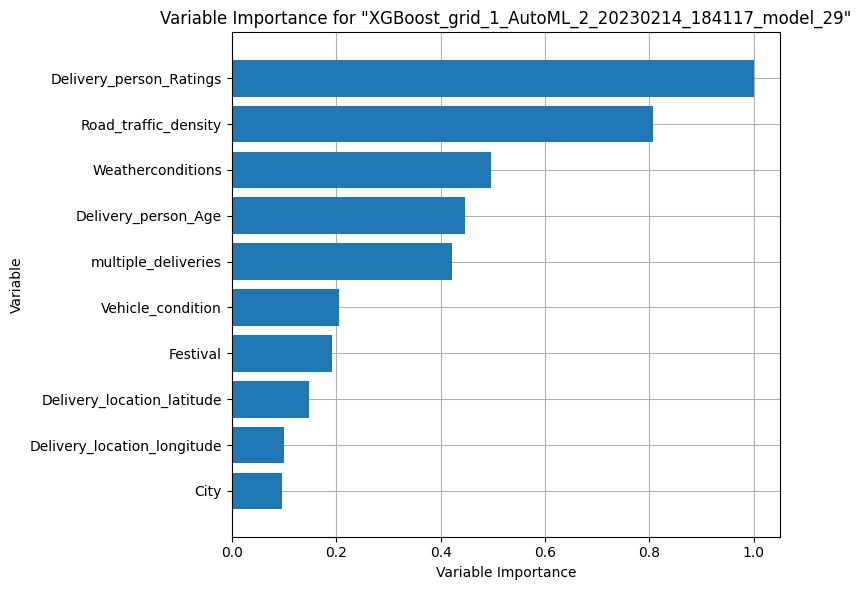

In [29]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])

#### Interpretting Feature Importance:
```
Delivery_person_Ratings has the highest impact on the prediction outcome. This suggests that the ratings of the delivery person play a significant role in determining the duration of delivery.

Road_traffic_density has the second highest impact on the prediction outcome. This suggests that the road traffic density at the time of delivery can affect the delivery time.

Vehicle_condition has a moderate impact on the duration. This suggests that the condition of the vehicle used for delivery can affect the target.

Delivery_person_Age has moderate impact on the prediction outcome. This suggests that the age of the delivery person can affect the delivery duration.

Weatherconditions has a moderate impact on the prediction outcome. This suggests that the weather conditions at the time of delivery can affect the delivery duration.
```

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

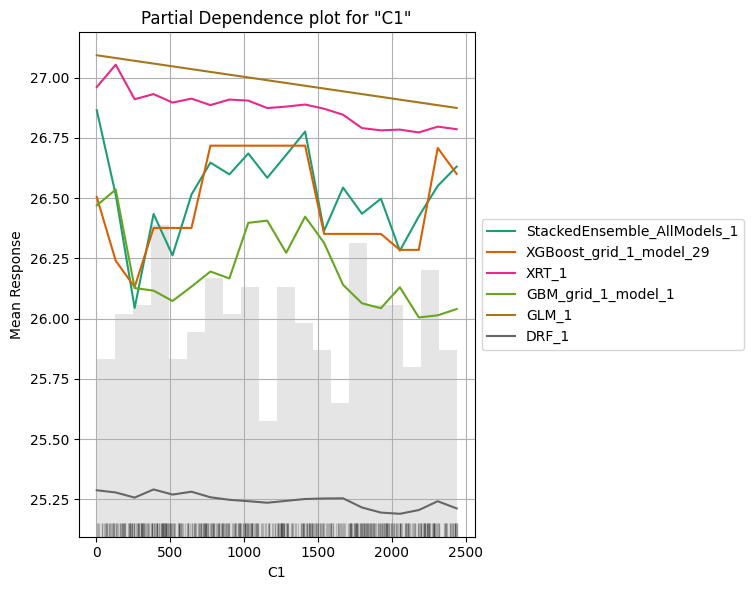

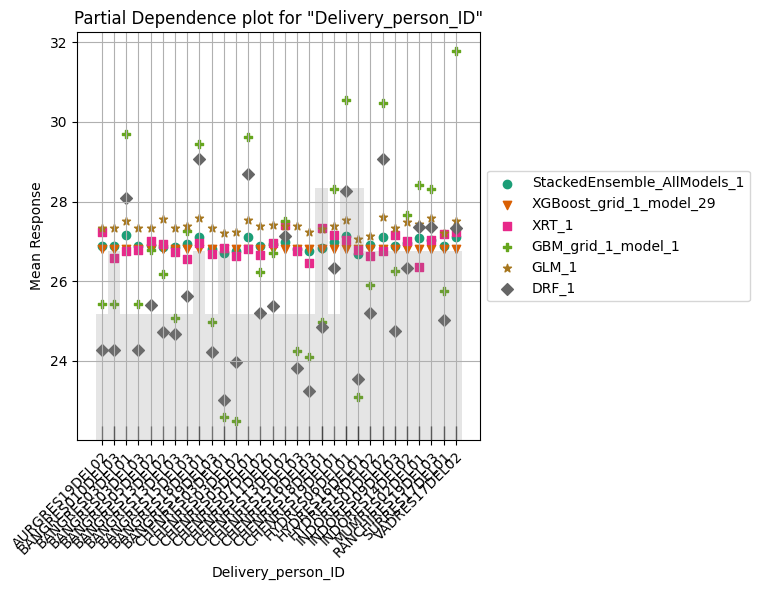

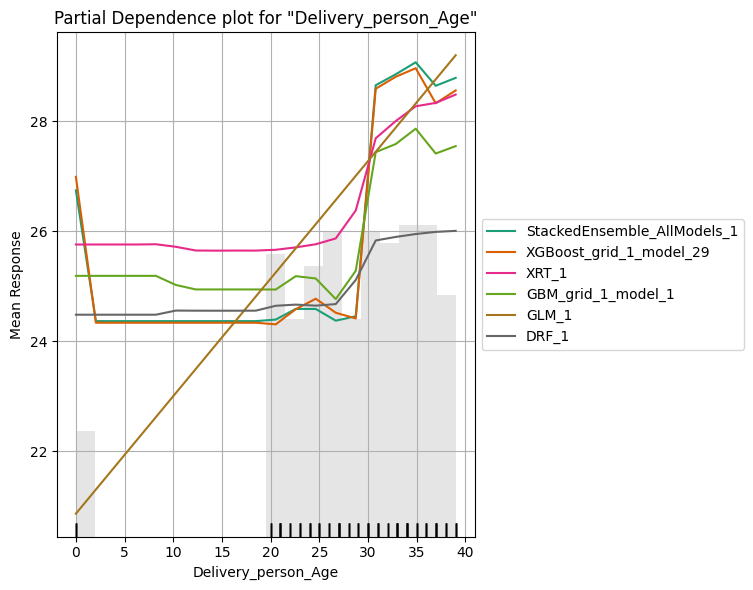

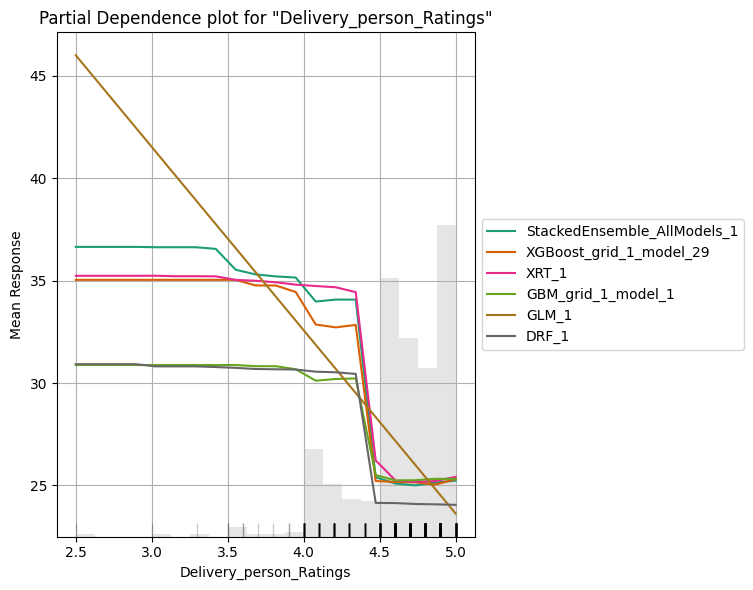

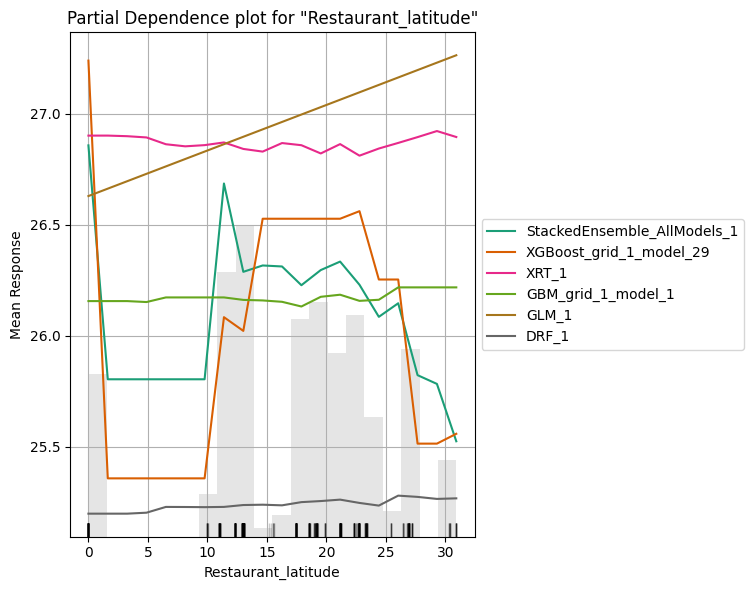

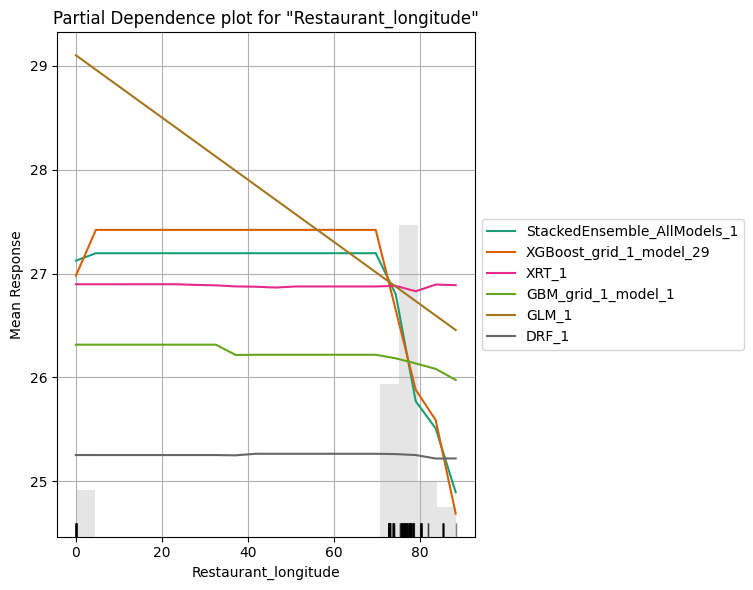

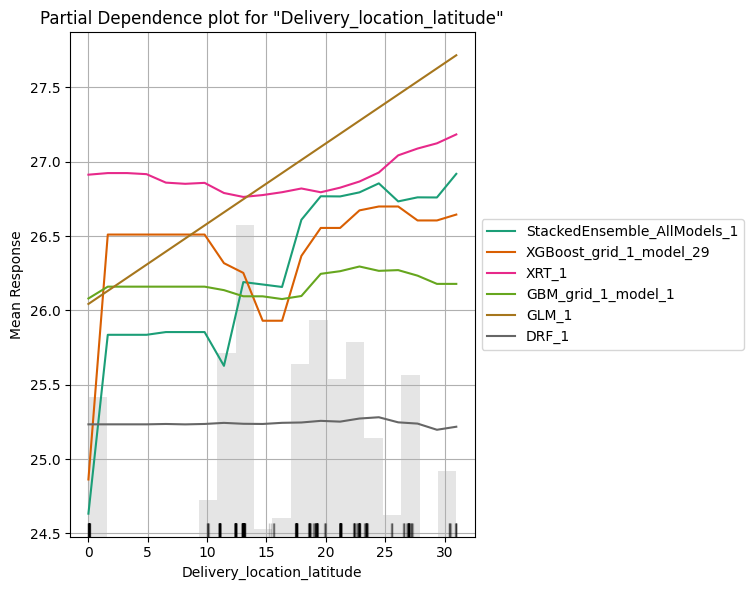

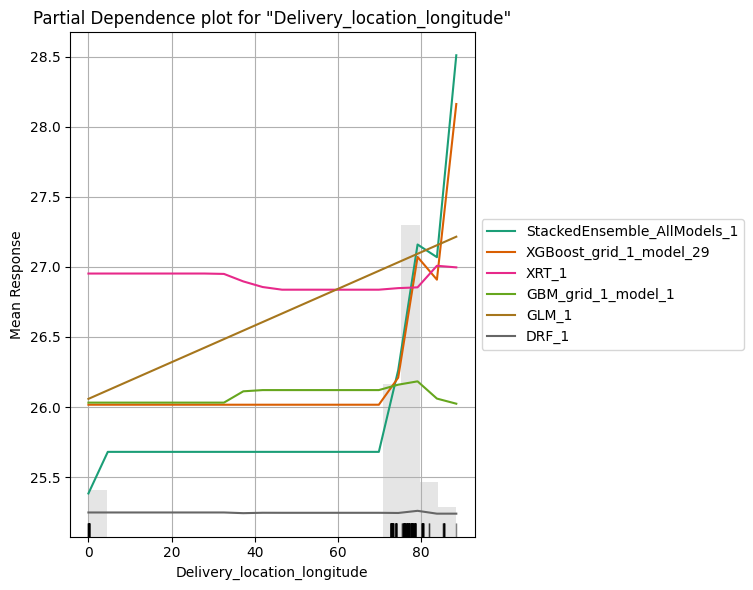

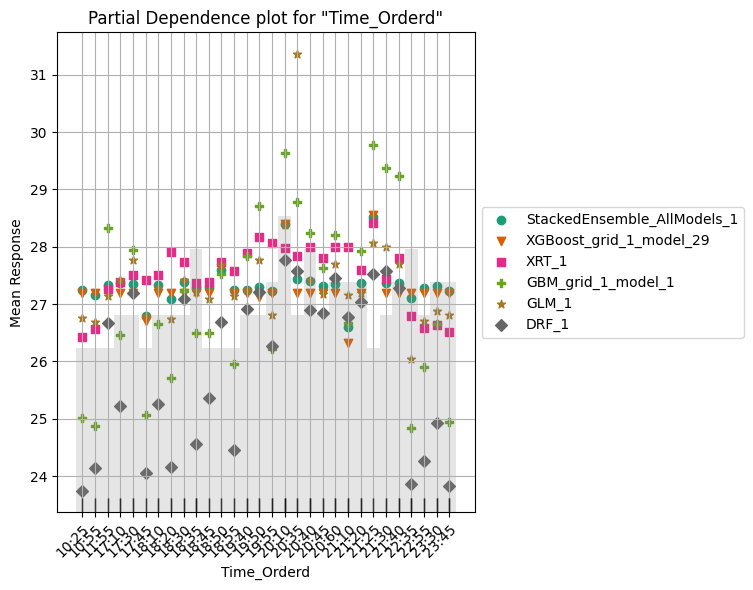

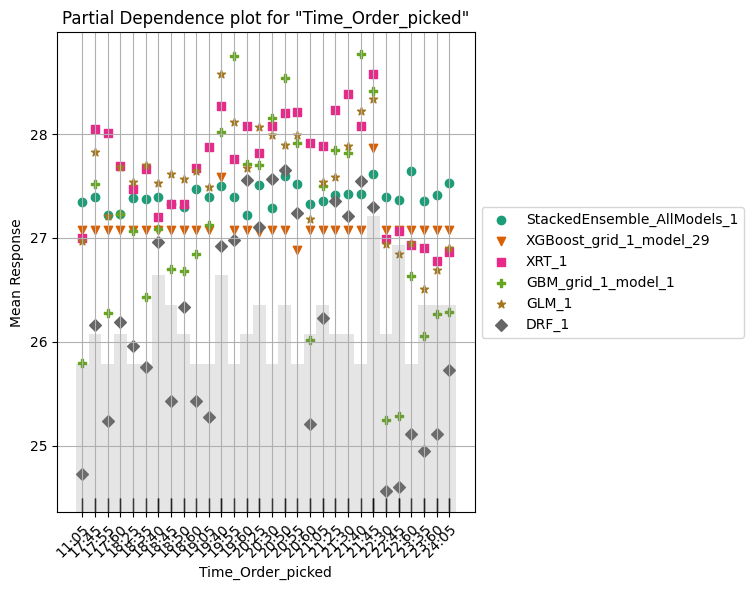

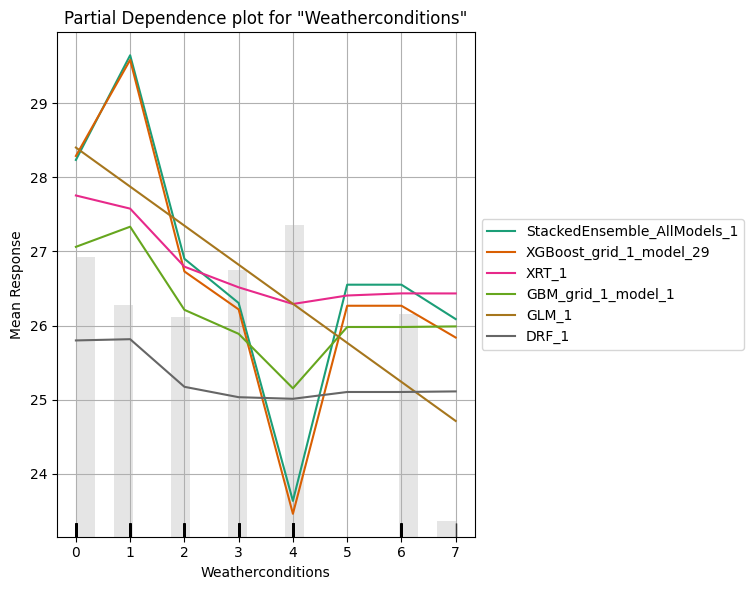

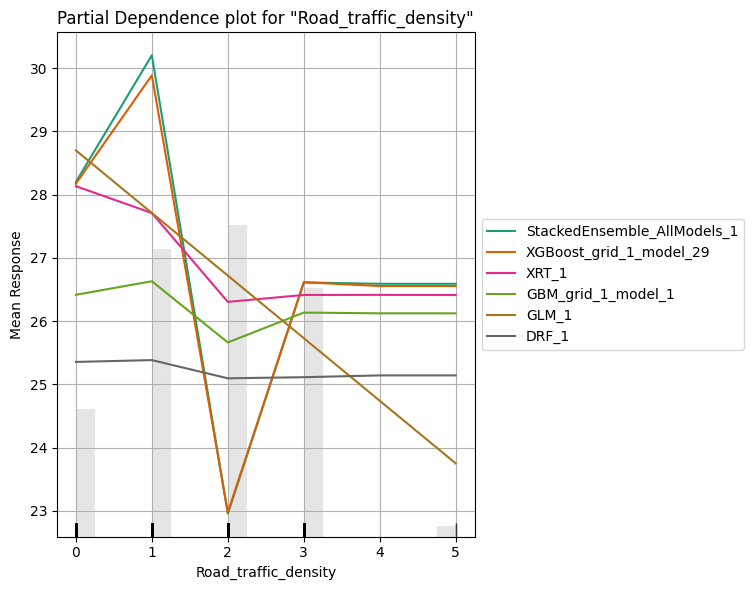

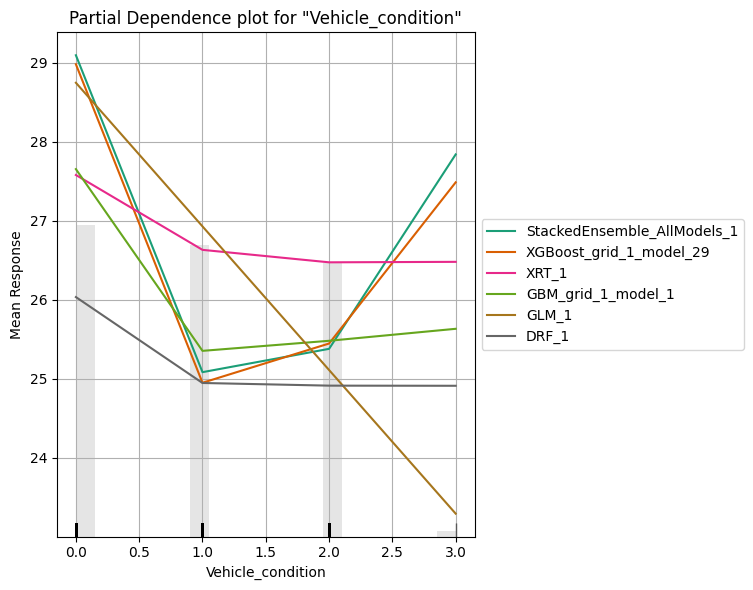

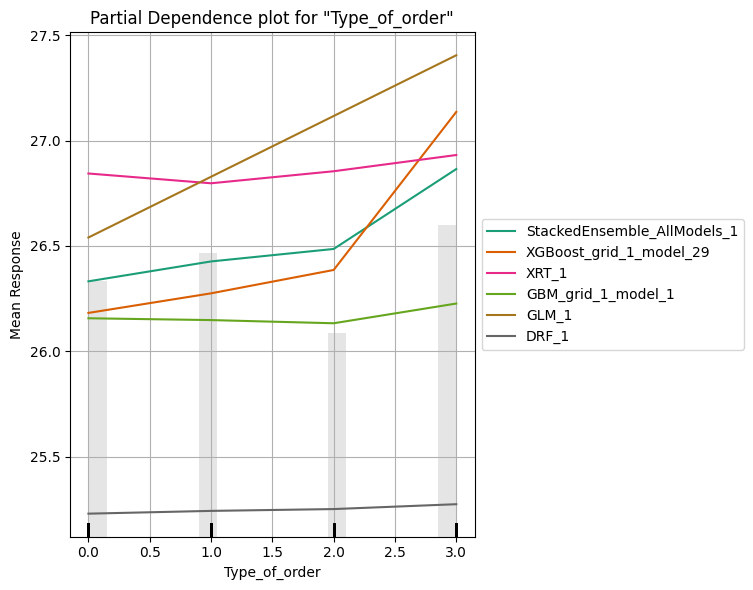

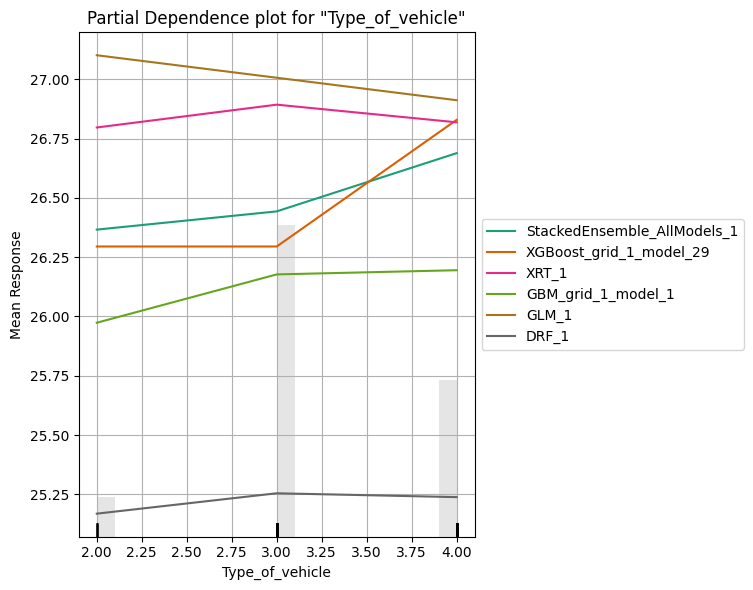

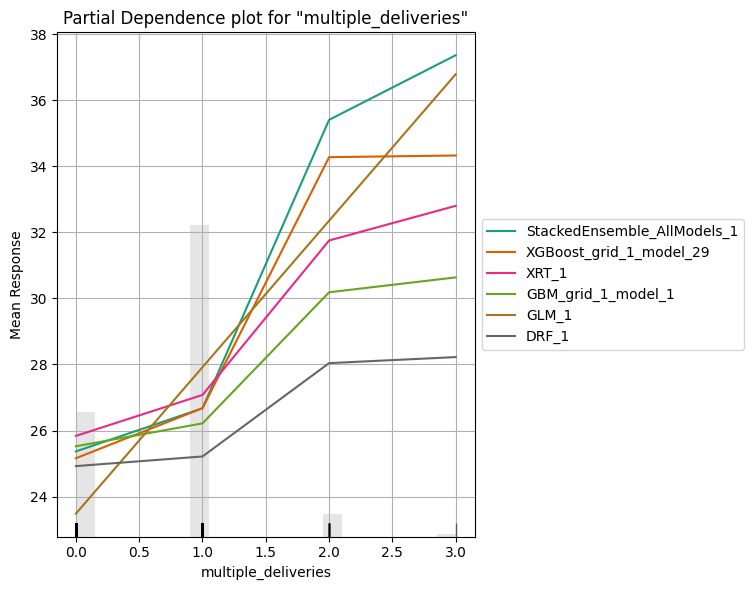

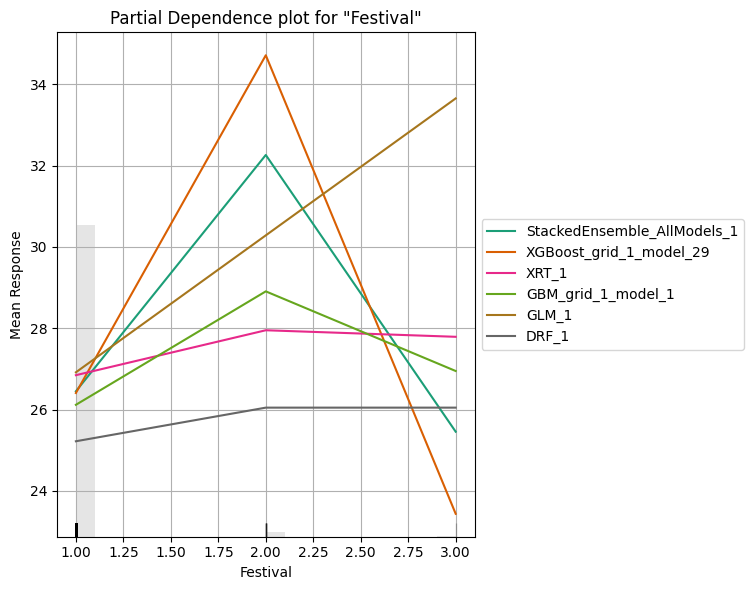

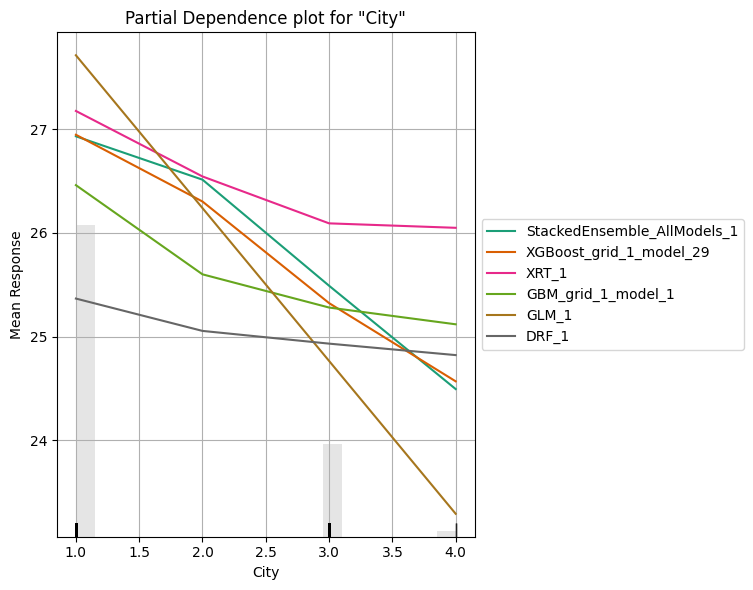

In [30]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['pdp'])

It can be concluded from the partial dependence ploat that the Stacked Ensemble Model has a consistent response to the Mean Response(Mean Delivery Time)

### Local Explainability

#### In addition, it also provides local explainability for individual records. We can input a H2OFrame into the frame argument and indicate which row we would like explained using the row_index argument. In this case we are explaining the results for row 15 of the test frame.

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

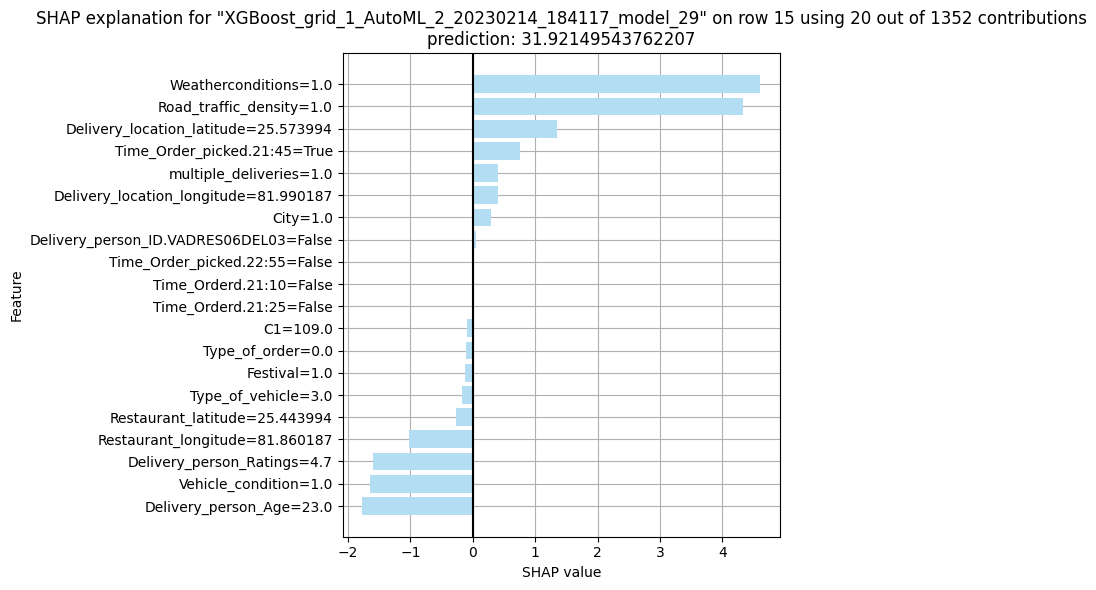

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [31]:
aml.explain_row(frame = test, row_index = 15, figsize = (8,6), exclude_explanations = "leaderboard")

The above plot explains how the time taken to deliver order in row 15 is 31.9 minutes.

### Conclusion

In this notebook, we examined how H2O AutoML can be used to:
1. Describe a dataset
2. Train models with minimal human inputs
3. Make predictions on a trained model
4. Explain the model’s predictions

### References:
1. [Automated Machine Learning with H2O](https://towardsdatascience.com/automated-machine-learning-with-h2o-258a2f3a203f)
2. [H2O AI AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)

### Licences:
MIT License

Copyright (c) 2023 AI SkunkWorks

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.